# 1. Подготовка

Здесь будем подгружать все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf

Подгружаем данные.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Меняем тип данных признака 'datetime' с текстового на временной.

In [6]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Устанавливаем в качестве индекса признак 'datetime'.

In [8]:
taxi.set_index('datetime', inplace=True)

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверяем, что индексы идут монотонно.

In [10]:
taxi.index.is_monotonic

True

Согласно заданию проводим ресемплирование длинной в час и агрегируем значения суммой.

In [11]:
taxi = taxi.resample('1H').sum()

In [12]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<b>Данные осмотрены и понятны, представляют собой временной ряд. Сделано ресемплирование отрезком в час.

# 2. Анализ данных

Посмотрим на график временного ряда.

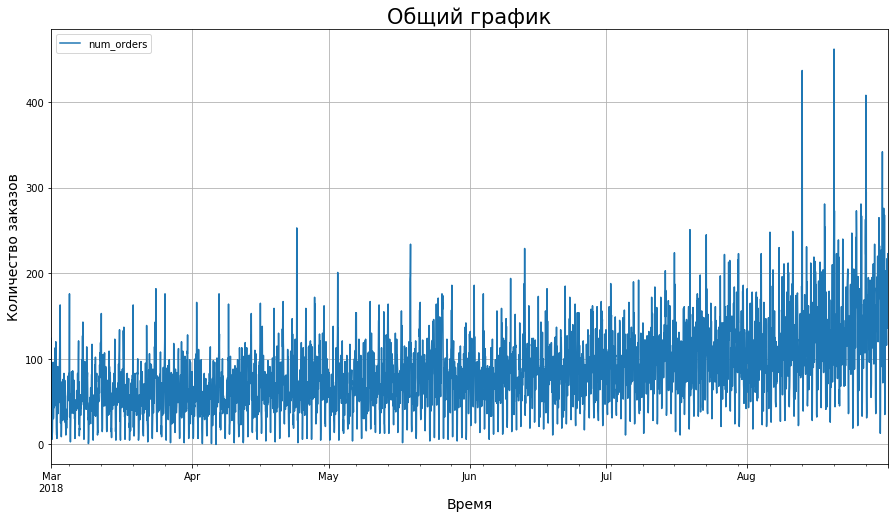

In [13]:
taxi.plot(figsize=(15, 8), grid=True);
plt.title('Общий график', fontsize=21);
plt.xlabel('Время', fontsize=14);
plt.ylabel('Количество заказов', fontsize=14);

Визуально не очень информативный график. Используем функцию 'seasonal_decompose()', которая раскладывает временной ряд на тренд, сезонность и остаток.

In [14]:
decomposed = seasonal_decompose(taxi)

Посмотрим на тренд.

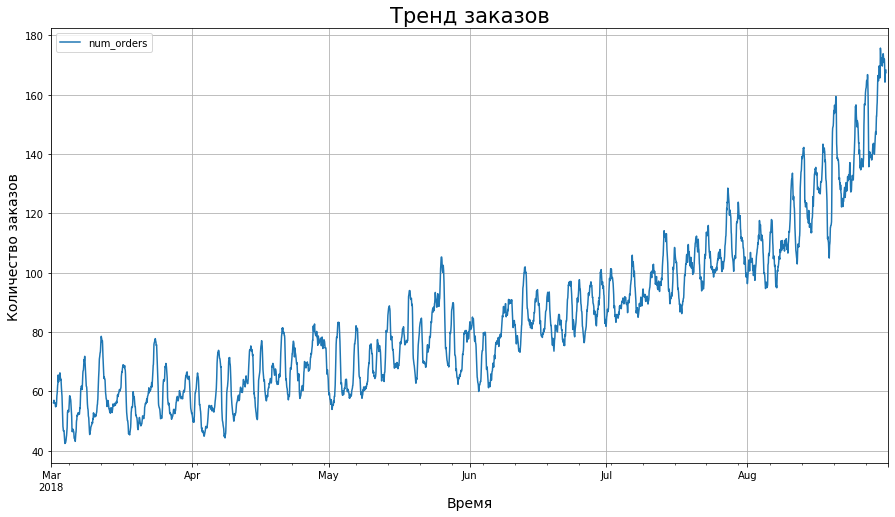

In [15]:
decomposed.trend.plot(figsize=(15, 8), grid=True);
plt.title('Тренд заказов', fontsize=21);
plt.xlabel('Время', fontsize=14);
plt.ylabel('Количество заказов', fontsize=14);

Видно, что от мая и до конца лета количество заказов растет, причем летом рост идет сильнее.

Посмотрим на сезонность.

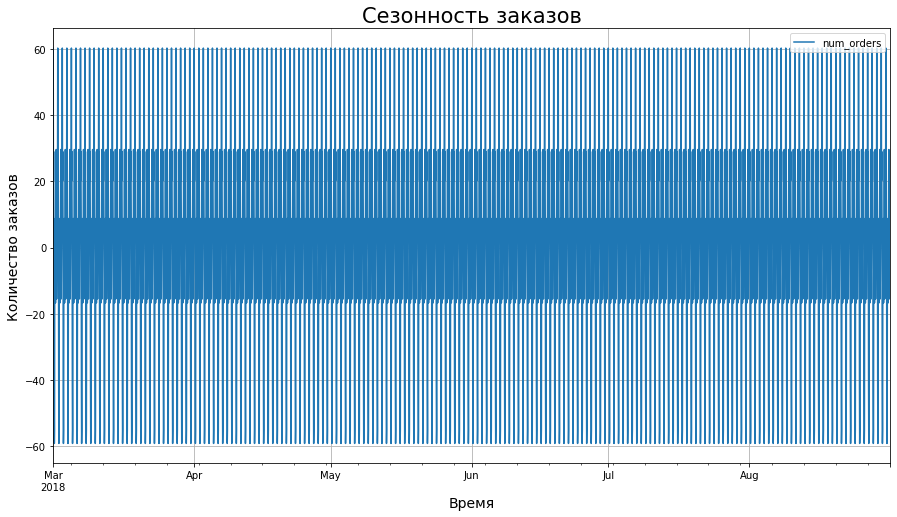

In [16]:
decomposed.seasonal.plot(figsize=(15, 8), grid=True);
plt.title('Сезонность заказов', fontsize=21);
plt.xlabel('Время', fontsize=14);
plt.ylabel('Количество заказов', fontsize=14);

Повторящиеся циклы вероятно имеются и проходят на коротком отрезке, посмотрим на отрезке в 2 дня.

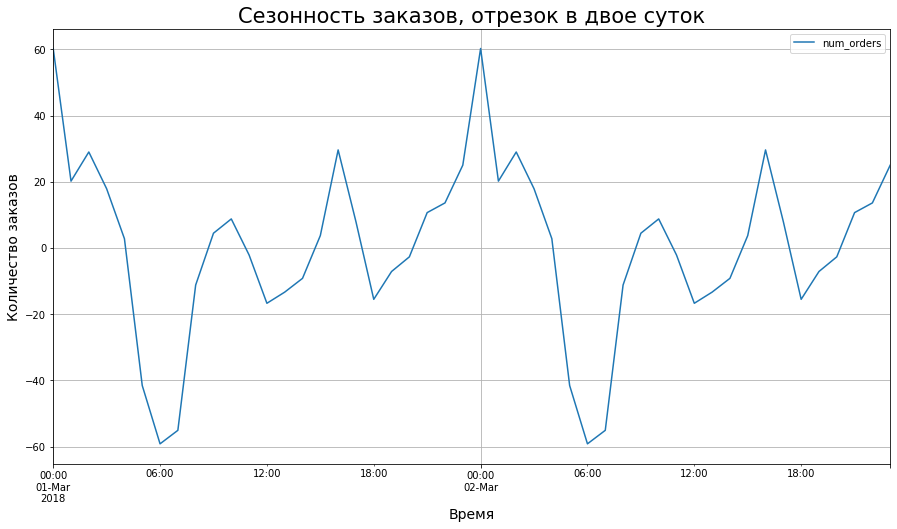

In [17]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15, 8), grid=True);
plt.title('Сезонность заказов, отрезок в двое суток', fontsize=21);
plt.xlabel('Время', fontsize=14);
plt.ylabel('Количество заказов', fontsize=14);

К 6 утра количество заказов сильно падает, днем выравнивается и ближе к вечеру/ночи выходит на пик.

Дабавим скользящее среднее и скользящее стандартное отклонение.

In [18]:
taxi_copy = taxi.copy()
taxi_copy['mean'] = taxi_copy['num_orders'].rolling(10).mean()
taxi_copy['std'] = taxi_copy['num_orders'].rolling(10).std()

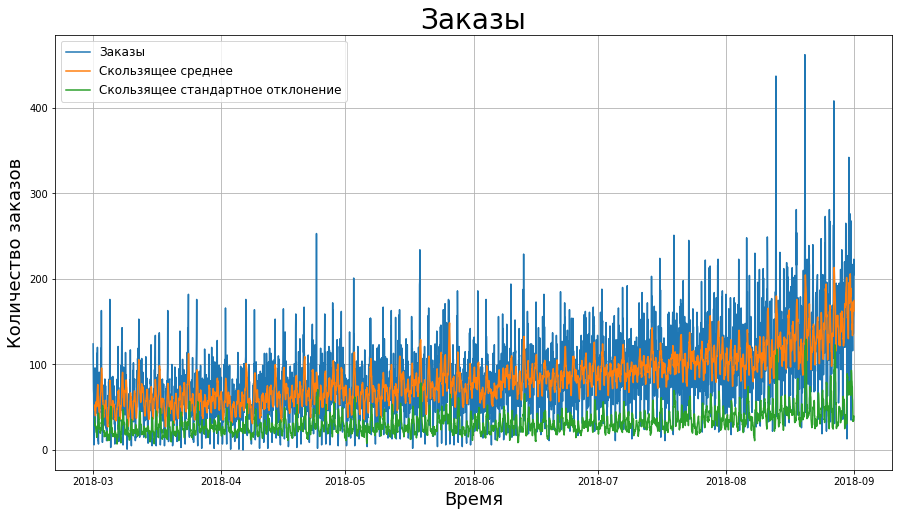

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))                       
ax.plot(taxi_copy['num_orders'], label='Заказы')
ax.plot(taxi_copy['mean'], label='Скользящее среднее')
ax.plot(taxi_copy['std'], label='Скользящее стандартное отклонение')
legend = ax.legend(loc='best', fontsize='12')
#legend.get_frame().set_facecolor('C7')
plt.title('Заказы', fontsize=28);
plt.xlabel('Время', fontsize=18);
plt.ylabel('Количество заказов', fontsize=18);
plt.grid(True)
plt.show()

Сделаем ресемплирование в день, чтобы график был более наглядным.

In [20]:
taxi_copy = taxi.resample('1D').sum()
taxi_copy['mean'] = taxi_copy['num_orders'].rolling(10).mean()
taxi_copy['std'] = taxi_copy['num_orders'].rolling(10).std()

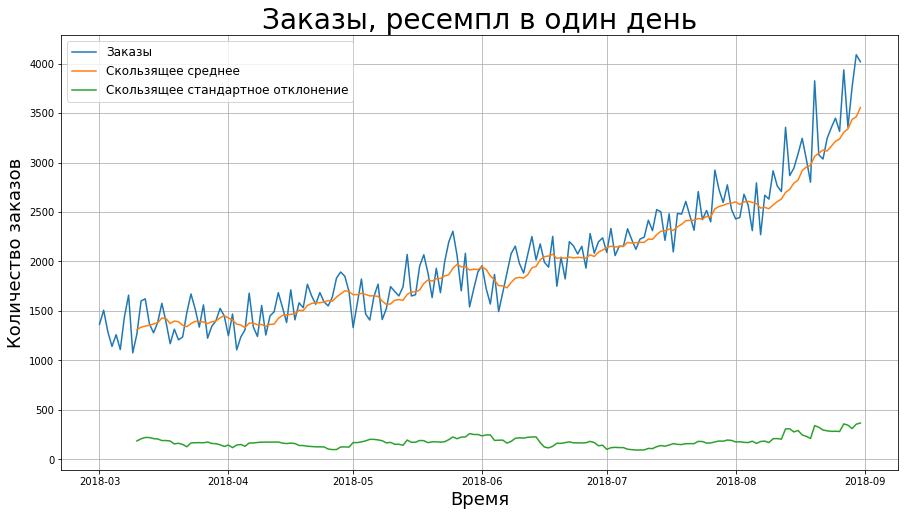

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))                       
ax.plot(taxi_copy['num_orders'], label='Заказы')
ax.plot(taxi_copy['mean'], label='Скользящее среднее')
ax.plot(taxi_copy['std'], label='Скользящее стандартное отклонение')
legend = ax.legend(loc='best', fontsize='12')
plt.title('Заказы, ресемпл в один день', fontsize=28);
plt.xlabel('Время', fontsize=18);
plt.ylabel('Количество заказов', fontsize=18);
plt.grid(True)
plt.show()

Более лучше виден рост заказов, скользящее стандартное отклонение примерно не меняется.

Проанализируем остатки и автокореляцию.

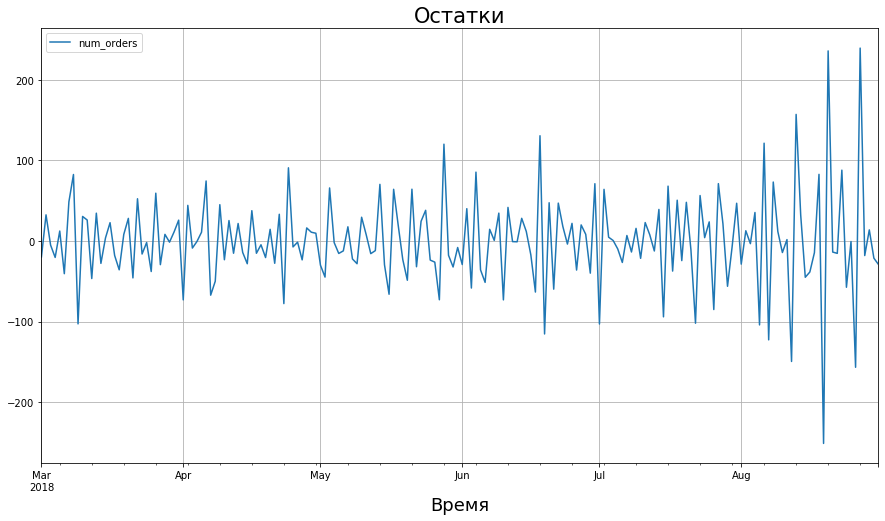

In [22]:
decomposed.resid.resample('1D').sum().plot(figsize=(15, 8), grid=True);
plt.title('Остатки', fontsize=21);
plt.xlabel('Время', fontsize=18);

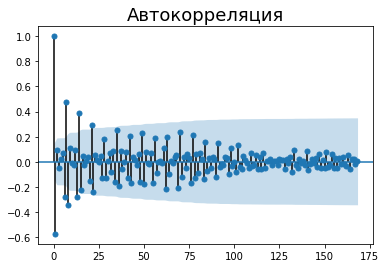

In [23]:
plot_acf(decomposed.resid.resample('1D').sum(), lags=24*7);
plt.title('Автокорреляция', fontsize=18);

В остатках отсутствует периодическая компонента и нет тренда, что говорит об адекватности модели.   
Из графика автокорреляции видно отсутствие сильной автокорреялции в остатках, что говорит о хорошей надежности модели.

<b>Мы проанализировали тренд и сезонность временного ряда. Обнаружили, что к 6-ти утра количество заказов сильно падает и их почти нет, ночью же, наоборот много, и это является сезонностью. Из тренда отметим сильный рост заказов летом.

# 3. Обучение моделей

## 3.1. Создаем признаки

Через функцию plot_acf посмотрим какие выбрать значения для параметра lag (отстающее значение).

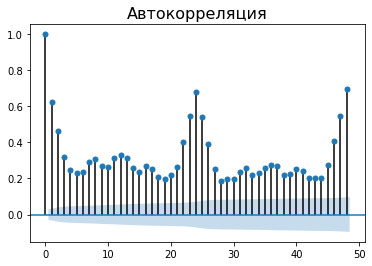

In [24]:
plot_acf(taxi['num_orders'], lags=48)
plt.title('Автокорреляция', fontsize=16);

После 24 часа идет такая же корреляция, тогда выберем lag 24.

Напишем функцию для создания признаков.

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(taxi, 24, 12)

Добавим еще отставание суточное.

In [27]:
for lag in range(2, 8):
        taxi['lag_24*{}'.format(lag)] = taxi['num_orders'].shift(24*lag)

In [28]:
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,rolling_mean,lag_24*2,lag_24*3,lag_24*4,lag_24*5,lag_24*6,lag_24*7
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Убираем пустые значения.

In [29]:
taxi = taxi.dropna()

In [30]:
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,rolling_mean,lag_24*2,lag_24*3,lag_24*4,lag_24*5,lag_24*6,lag_24*7
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,127.0,108.0,76.0,50.0,...,24.0,121.0,100.0,69.250000,42.0,86.0,75.0,163.0,90.0,124.0
2018-03-08 01:00:00,78,3,8,3,1,143.0,94.0,127.0,108.0,76.0,...,66.0,24.0,121.0,78.333333,75.0,176.0,60.0,108.0,120.0,85.0
2018-03-08 02:00:00,65,3,8,3,2,78.0,143.0,94.0,127.0,108.0,...,73.0,66.0,24.0,80.250000,36.0,32.0,26.0,25.0,75.0,71.0
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,...,10.0,73.0,66.0,82.083333,49.0,51.0,42.0,64.0,64.0,66.0
2018-03-08 04:00:00,60,3,8,3,4,68.0,65.0,78.0,143.0,94.0,...,19.0,10.0,73.0,83.500000,30.0,34.0,27.0,44.0,20.0,43.0


## 3.2. Делим выборки.

In [31]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    taxi.drop(['num_orders'], axis=1), taxi.num_orders, shuffle=False, test_size=0.20, random_state=12345)

In [32]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, shuffle=False, test_size=0.50, random_state=12345)

Сделаем константную модель, чтобы проверять модели на адекватность.

In [33]:
predicted_train_median = pd.Series(target_train.median(), index=target_train.index)
mse_train_median = mean_squared_error(target_train, predicted_train_median)
rmse_train_median = mse_train_median**0.5

## 3.3. Модель LinearRegression

In [34]:
model = LinearRegression()
model.fit(features_train, target_train)

predicted_train = model.predict(features_train)
rmse_train = mean_squared_error(target_train, predicted_train)**0.5

predicted_valid = model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predicted_valid)**0.5

print("RMSE обучающей выборки:", rmse_train)
print("RMSE обучающей выборки константной модели:", rmse_train_median)
print("RMSE валидационной выборки: ", rmse_valid)

RMSE обучающей выборки: 20.014664999532034
RMSE обучающей выборки константной модели: 35.94524480228796
RMSE валидационной выборки:  29.484918770305033


Отметим, что метрика на обучающей выборке получилась лучше, чем у медианной модели, что говорит об адекватности модели.

Отобразим на графике предсказания, чтобы понять, где основные "непопадания".

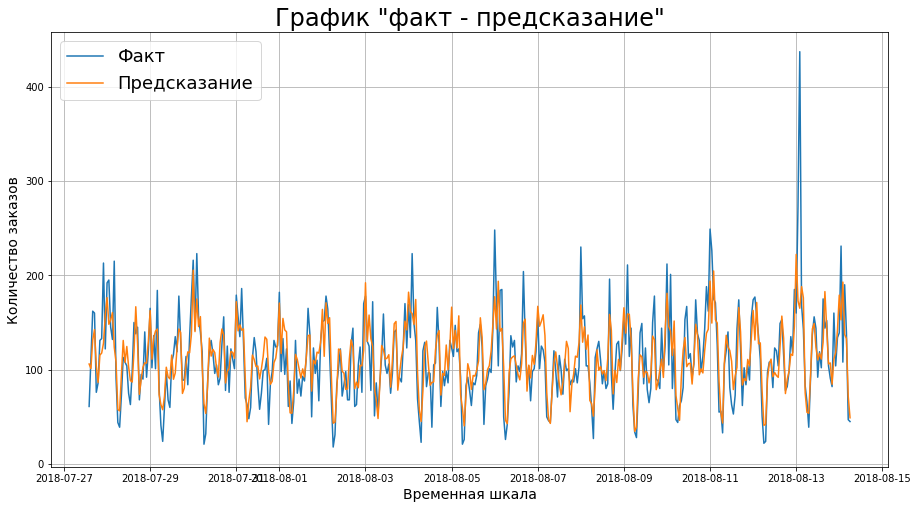

In [35]:
plt.figure(figsize=(15,8))
plt.plot(target_valid, label='Факт')
plt.plot(pd.Series(predicted_valid, index=target_valid.index), label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

Выведем также автокорреляцию предсказаний.

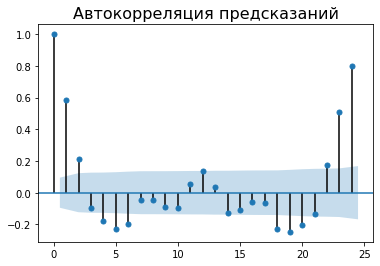

In [36]:
plot_acf(pd.Series(predicted_valid, index=target_valid.index), lags=24);
plt.title('Автокорреляция предсказаний', fontsize=16);

Где-то на 13ом дне имеется выброс, посмотрим ближе.

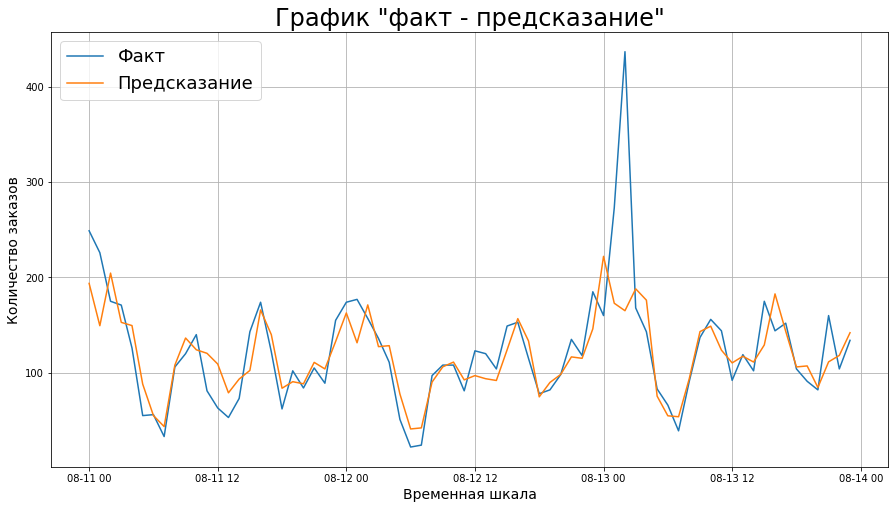

In [37]:
plt.figure(figsize=(15,8))
plt.plot(target_valid['2018-08-11':'2018-08-13'], label='Факт')
plt.plot(pd.Series(predicted_valid, index=target_valid.index)['2018-08-11':'2018-08-13'], label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

Видно, что модель плохо справилась с выбросом, возможно из-за этого идут основные расхождения.

## 3.4. Модель DecisionTreeRegressor

In [38]:
%%time

rmse_train_best = 100
samples_split_best = 0
samples_leaf_best = 0

for samples_split in [6, 10, 14, 18]:
    for samples_leaf in [7, 9, 11]:
        model = DecisionTreeRegressor(min_samples_split=samples_split, min_samples_leaf=samples_leaf, random_state=12345)
        model.fit(features_train, target_train)
        predicted_train = model.predict(features_train)
        rmse_train = mean_squared_error(target_train, predicted_train)**0.5

        if rmse_train_best > rmse_train:
            rmse_train_best = rmse_train
            samples_split_best = samples_split
            samples_leaf_best = samples_leaf        
        print('*****************************')
        print('samples_split:', samples_split, 'samples_leaf:', samples_leaf)       
        print('RMSE_train:', rmse_train)
        
model = DecisionTreeRegressor(min_samples_split=samples_split_best, min_samples_leaf=samples_leaf_best, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predicted_valid)**0.5

print('--------------------------------------------------------')
print('Лучшие параметры при samples_split = {}, samples_leaf = {}'.format(samples_split_best, samples_leaf_best))
print("RMSE обучающей выборки:", rmse_train_best)
print("RMSE обучающей выборки константной модели:", rmse_train_median)
print("RMSE валидационной выборки: ", rmse_valid)
print('--------------------------------------------------------')

*****************************
samples_split: 6 samples_leaf: 7
RMSE_train: 12.988201644402555
*****************************
samples_split: 6 samples_leaf: 9
RMSE_train: 14.28001804855633
*****************************
samples_split: 6 samples_leaf: 11
RMSE_train: 15.233724233027939
*****************************
samples_split: 10 samples_leaf: 7
RMSE_train: 12.988201644402555
*****************************
samples_split: 10 samples_leaf: 9
RMSE_train: 14.28001804855633
*****************************
samples_split: 10 samples_leaf: 11
RMSE_train: 15.233724233027939
*****************************
samples_split: 14 samples_leaf: 7
RMSE_train: 12.988201644402555
*****************************
samples_split: 14 samples_leaf: 9
RMSE_train: 14.28001804855633
*****************************
samples_split: 14 samples_leaf: 11
RMSE_train: 15.233724233027939
*****************************
samples_split: 18 samples_leaf: 7
RMSE_train: 13.82200625102164
*****************************
samples_split: 18 sample

## 3.5. Модель RandomForestRegressor

In [39]:
%%time

rmse_train_best = 100
estim_best = 0
depth_best = 0

for estim in range(10, 131, 30):
    for depth in range(1, 18, 4):     
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_train = model.predict(features_train)
        rmse_train = mean_squared_error(target_train, predicted_train)**0.5

        if rmse_train_best > rmse_train:
            rmse_train_best = rmse_train
            estim_best = estim
            depth_best = depth        
        print('*****************************')
        print('estim:', estim, 'depth:', depth)       
        print('RMSE_train:', rmse_train)
        
model = RandomForestRegressor(n_estimators=estim_best, max_depth=depth_best, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predicted_valid)**0.5

print('--------------------------------------------------------')
print('Лучшие параметры при estim = {}, depth = {}'.format(estim_best, depth_best))
print("RMSE обучающей выборки:", rmse_train_best)
print("RMSE обучающей выборки константной модели:", rmse_train_median)
print("RMSE валидационной выборки: ", rmse_valid)
print('--------------------------------------------------------')

*****************************
estim: 10 depth: 1
RMSE_train: 27.23895152077123
*****************************
estim: 10 depth: 5
RMSE_train: 18.917917076285622
*****************************
estim: 10 depth: 9
RMSE_train: 13.562545305398489
*****************************
estim: 10 depth: 13
RMSE_train: 9.99439586068379
*****************************
estim: 10 depth: 17
RMSE_train: 9.017189840212321
*****************************
estim: 40 depth: 1
RMSE_train: 27.406727928884543
*****************************
estim: 40 depth: 5
RMSE_train: 18.731375837946473
*****************************
estim: 40 depth: 9
RMSE_train: 12.902852275371997
*****************************
estim: 40 depth: 13
RMSE_train: 8.965111370767284
*****************************
estim: 40 depth: 17
RMSE_train: 7.895724568089688
*****************************
estim: 70 depth: 1
RMSE_train: 27.339779771953513
*****************************
estim: 70 depth: 5
RMSE_train: 18.68221011583954
*****************************
estim: 70 dep

<b>Мы обучили три модели и нашли оптимальные гиперпараметры при которых RMSE на валидационной выборке имеет минимальное значение.

# 4. Тестирование моделей

Рассчитаем константную медианную модель на тестовой выборке.

In [40]:
predicted_test_median = pd.Series(target_test.median(), index=target_test.index)
mse_test_median = mean_squared_error(target_test, predicted_test_median)
rmse_test_median = mse_test_median**0.5
print('RMSE тестовой выборки константной модели:',rmse_test_median)

RMSE тестовой выборки константной модели: 59.11464434867716


## 4.1. Модель LinearRegression

In [41]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

predicted_test = model.predict(features_test)
rmse_test = mean_squared_error(target_test, predicted_test)**0.5

print("RMSE тестовой выборки:", rmse_test)
print('RMSE тестовой выборки константной модели:',rmse_test_median)

RMSE тестовой выборки: 34.226664411863304
RMSE тестовой выборки константной модели: 59.11464434867716
CPU times: user 87.2 ms, sys: 132 ms, total: 219 ms
Wall time: 205 ms


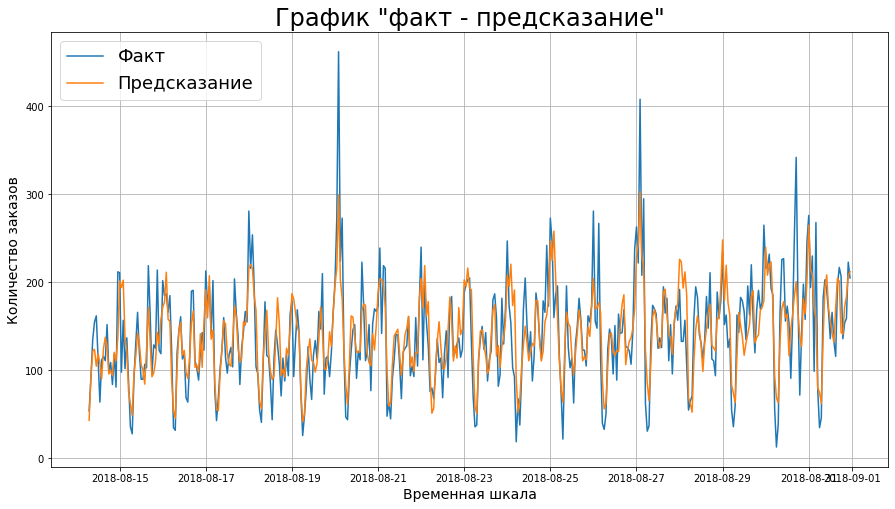

In [42]:
plt.figure(figsize=(15,8))
plt.plot(target_test, label='Факт')
plt.plot(pd.Series(predicted_test, index=target_test.index), label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

Видим также как и на валидной выборке модель плохо справляется с выбросами, что видно на графике ниже.

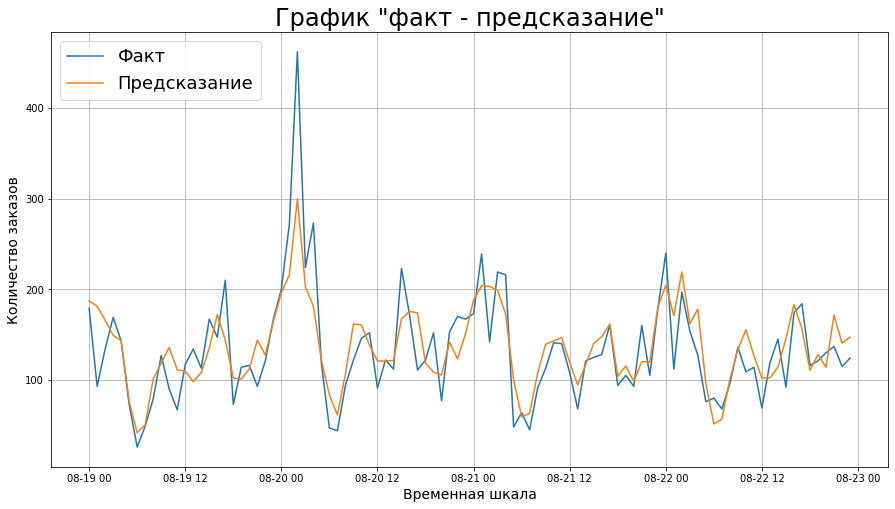

In [43]:
plt.figure(figsize=(15,8))
plt.plot(target_test['2018-08-19':'2018-08-22'], label='Факт')
plt.plot(pd.Series(predicted_test, index=target_test.index)['2018-08-19':'2018-08-22'], label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

### 4.2. Модель DecisionTreeRegressor

In [44]:
%%time
model = DecisionTreeRegressor(min_samples_split=6, min_samples_leaf=7, random_state=12345)
model.fit(features_train, target_train)

predicted_test = model.predict(features_test)
rmse_test = mean_squared_error(target_test, predicted_test)**0.5

print("RMSE тестовой выборки:", rmse_test)
print('RMSE тестовой выборки константной модели:',rmse_test_median)

RMSE тестовой выборки: 48.43654388600085
RMSE тестовой выборки константной модели: 59.11464434867716
CPU times: user 87 ms, sys: 46 µs, total: 87 ms
Wall time: 97.4 ms


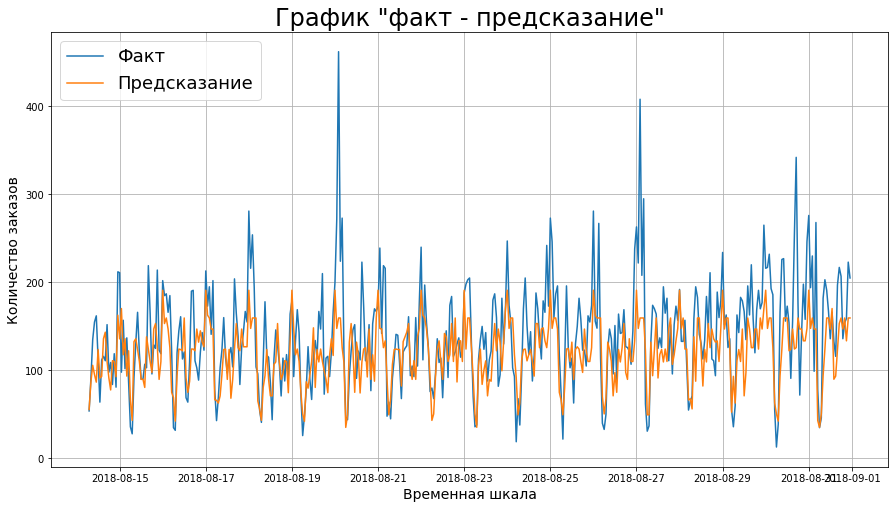

In [45]:
plt.figure(figsize=(15,8))
plt.plot(target_test, label='Факт')
plt.plot(pd.Series(predicted_test, index=target_test.index), label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

## 4.3. Модель RandomForestRegressor

In [46]:
%%time
model = RandomForestRegressor(n_estimators=130, max_depth=7, random_state=12345)
model.fit(features_train, target_train)

predicted_test = model.predict(features_test)
rmse_test = mean_squared_error(target_test, predicted_test)**0.5

print("RMSE тестовой выборки:", rmse_test)
print('RMSE тестовой выборки константной модели:',rmse_test_median)

RMSE тестовой выборки: 44.76601285420227
RMSE тестовой выборки константной модели: 59.11464434867716
CPU times: user 4.73 s, sys: 3.98 ms, total: 4.73 s
Wall time: 4.86 s


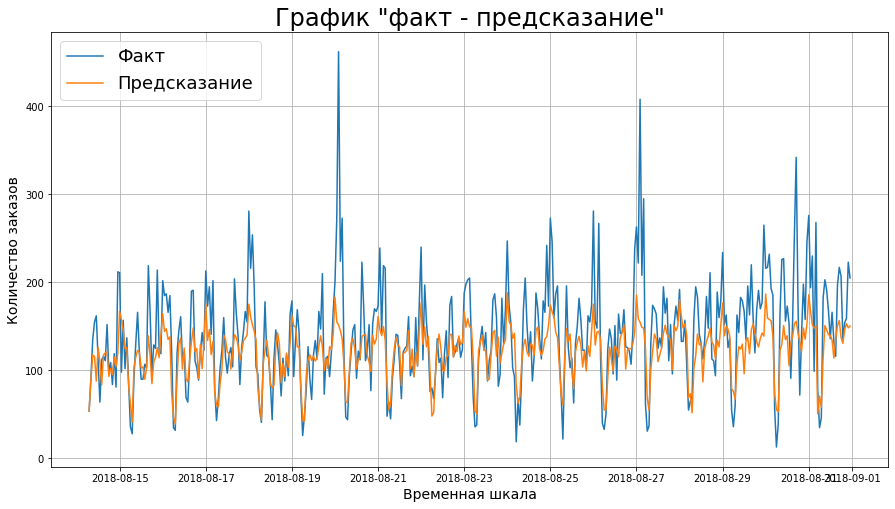

In [47]:
plt.figure(figsize=(15,8))
plt.plot(target_test, label='Факт')
plt.plot(pd.Series(predicted_test, index=target_test.index), label='Предсказание')
plt.legend(loc='upper left', fontsize=18)
plt.title('График "факт - предсказание"', fontsize=24);
plt.xlabel('Временная шкала', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True)
plt.show()

<b>Всем модели имеют хороший результа и получили метрику лучше медианной константной, что говорит об их адеватности. Лучшее значение RMSE =  34.23 на тестовой выборке имеет модель LinearRegression. Тем не менее пространство для улучшения результатов есть, можно поварьировать с признаками, попробовать добавить еще дополнительные. Имеет смысл добавить еще несколько моделей, например: CatBoost, LightGBM.   
    В целом хороших резльтатов удалось получить, засчет анализа датасета и добавления корректных признаков, таких как: календарные признаки, отстающие значения, скользящее среднее.